In [47]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.linear_model import OrthogonalMatchingPursuit
from sklearn.linear_model import Lars
from scipy import signal
from scipy.fftpack import fft, ifft, dct, idct
from scipy.linalg import dft

import tensorflow as tf


import MEArec as mr
import MEAutility
import spikeinterface as si
import spikeinterface.toolkit as st
import spikeinterface.sorters as ss
import spikeinterface.extractors as se
import spikeinterface.comparison as sc
import spikeinterface.sorters as ssort
import spikeinterface.widgets as sw

In [48]:
## 1D stft from scratch

# def stft_hann(data, fft_size):
#     hop_size = fft_size//4
#     total_segments = np.int32(np.ceil(data.shape[-1] / np.float32(hop_size)))
#     window = np.hanning(fft_size)
#     proc = np.concatenate((data, np.zeros(fft_size))) #padding end of data 
#     result = np.empty((total_segments, fft_size), dtype=np.float32)    
#     for i in range(total_segments):                      
#         current_hop = hop_size * i                        
#         segment = proc[current_hop:current_hop+fft_size]  
#         windowed = segment * window                      
#         padded = np.append(windowed, np.zeros(fft_size))           
#         spectrum = np.fft.fft(padded) / np.sqrt(fft_size)
#         result[i, :] = spectrum[:fft_size]
#     return result

In [49]:
# pooling t highest coefficients of x matrix

def make_sparse(x,t):
    l = x.reshape(-1)
    p = np.argsort(np.abs(l))[-t]
    s = np.ma.masked_where(np.abs(x) < np.abs(l[p]), x)
    y = np.ma.filled(s.astype(float), 0.0)
    return y

In [50]:
# Input: 
# RIC, signal length (l), sparsity level (k)
# Output: # measurements, RIP satisfiable probability    

def pre_rip(k1, delta, l, k):  
    # k1: arbiteraty but, we need to choose it large enough to have atleast 10% measurements over all length
    # as it affects the number of measurements that should apply to have RIP measurement matrix so, we 
    # need to tune it as a hyperparameter
    
    #k_star
    k_star = 2/(1-np.log(2))
    # k2
    k2 = delta**2 / (2*k_star) - 1 / (k1*np.log(42*np.e / delta))
    # number of measurements
    nm = int( round(k1*k*np.log(l/k) ) )
    # probability of RIP satisfaction
    p = 1 - 2*np.exp(k2*nm)
    return nm, p

In [51]:
# input: # measurements, # channels, temporal window size, starting and ending window positions
# output: transform matrix (phi) from data to measurements, measurements vector (y), spatiotemporal DFT

def cs_matrices(nm, nch, win_size, start_win, end_win):
    df_time = dft(win_size, 'sqrtn')
    df_space = dft(nch, 'sqrtn')
    df = np.kron(df_space, df_time)
    M = np.random.uniform(0, 1/np.sqrt(nm), (nm,win_size*nch))
    phi = np.dot(M, np.conjugate(df).T)
    y = np.dot(M, v1[:,start_win:end_win].reshape(-1))
    return phi, y, df

In [52]:
# padding data with pad_size

def pad(v, pad_size):
    v_pad = np.zeros((nch, len(v[1])+pad_size))
    for k1 in range(nch):
        v_pad[k1,:] = np.pad(v[k1,:], (0, pad_size),
                    mode='constant', constant_values=0)
    return v_pad

In [140]:
# reading recording into numpy array

c = 10 #cell population
k = 0 # config
recording, gt = se.read_mearec('data/MEA10*10/recgen_cell_%s/%s.h5'%(c,k))
sv = recording.get_traces().T


### build a pipline for recordings

In [54]:
# init: recording data, window ( for example: boxcar, hann, ...), hop: hoppingsize, pad_len: length of padding
# window, hopping, and padding should compatible with eachother to adjust start and ending process.

# win_gen: generate batches with input window

# win_set: generate a dataset of windowed batches

class Windowing_layer:
    def __init__(self, recording, window, hop, pad_len):
        self.v = recording
        self.w = window
        self.h = hop
        self.pl = pad_len
    
    def win_gen(self):
        nch, ns = self.v.shape
        m = ns//len(self.w)
        for i in range(m):
            ss = np.pad(self.v[:, i*self.h:i*self.h+len(self.w)]*self.w,
                   (0, self.pl), mode='constant', constant_values=0)
            yield ss
            
    def win_set(self):
        nch, ns = self.v.shape
        d = tf.data.Dataset.from_generator(self.win_gen, 
                                              output_types=tf.float32, 
                                              output_shapes=(nch,len(self.w)))
        return d

In [55]:
# init: d: windowed dataset, m: measurement matrix, phi: transformed matrix, k_sparse

# cs_gen: generate the Model based signal recovery (OMP or LARS) for each batch

# cs_recovery: build a dataset of recovered signal

class cs_layer:
    def __init__(self, d, m, phi, k_sparse):
        self.d = d
        self.m = m
        self.phi = phi
        self.k = k_sparse    

    def cs_gen(self):

        for w in self.d:
            y = np.dot(m, w.numpy().reshape(-1))
            omp = OrthogonalMatchingPursuit(n_nonzero_coefs=k_sparse, normalize=False)
            omp.fit(phi.real, y)
            coef_omp_real = omp.coef_ 
            omp.fit(phi.imag, y)
            coef_omp_img = omp.coef_ 
            coef_omp = coef_omp_real + 1j*coef_omp_img   
            yield coef_omp
            
    def cs_recovery(self):
        d = tf.data.Dataset.from_generator(self.cs_gen, 
                                              output_types=tf.complex64)
        return d
        

In [141]:
win_size = 100
hop = win_size # for now let's just consider no overlapping
win = signal.windows.boxcar(win_size, sym=True) # using simple boxcar window
pl = 0
rec = sv[:,1000:2000] # the all data sv can feed to the pipline
nch, ns = rec.shape
d = Windowing_layer(rec, win, hop, pl).win_set()
print(d)

<FlatMapDataset element_spec=TensorSpec(shape=(100, 100), dtype=tf.float32, name=None)>


In [142]:
# test: to see the data in dataset and original recordings are same

v_test = np.zeros((nch,ns))
for i, elm in enumerate(d):
    v_test[:,i*win_size:(i+1)*win_size]=elm

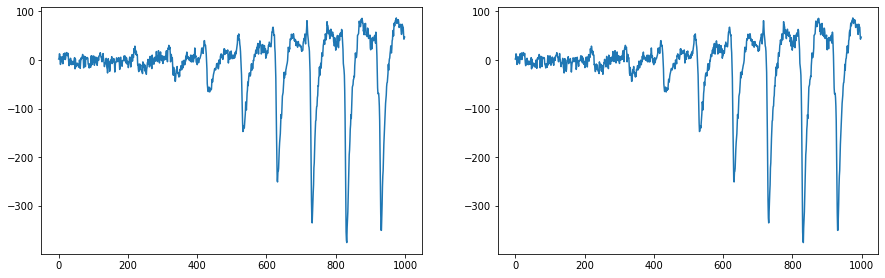

In [143]:
plt.figure(figsize=(15,10))
plt.subplot(221)
plt.plot(rec[40:50,100:200].reshape(-1))
plt.subplot(222)
plt.plot(v_test[40:50,100:200].reshape(-1))

<AxesSubplot:>

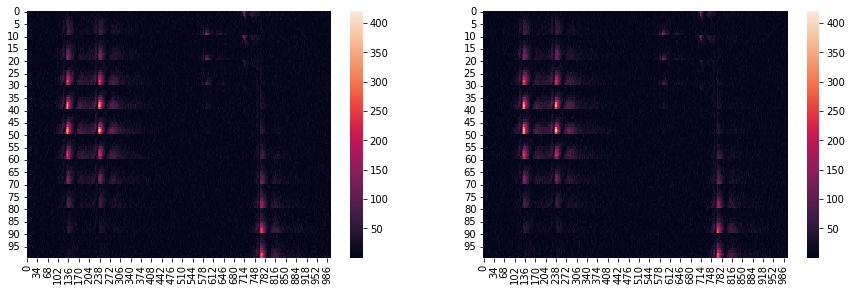

In [144]:
plt.figure(figsize=(15,10))
plt.subplot(221)
sns.heatmap(abs(rec))
plt.subplot(222)
sns.heatmap(abs(v_test))

In [147]:
k1 = 1
k = nch*win_size//100
delta = .5
l = nch*win_size
nm, p = pre_rip(k1, delta, l, k)
print('# of measurements = %s or %s %%'%(nm, 100*nm/(nch*win_size)))
print('probability of satisfiable RIP = ', p)

# of measurements = 461 or 4.61 %
probability of satisfiable RIP =  1.0


In [148]:
df = dft(nch*win_size, 'sqrtn')
m = np.random.uniform(0, 1/np.sqrt(nm), (nm, nch*win_size))
phi = np.dot(m, np.conjugate(df).T)
print('dft shape: ',df.shape)
print('dft shape: ',m.shape)
print('dft shape: ',phi.shape)

dft shape:  (10000, 10000)
dft shape:  (461, 10000)
dft shape:  (461, 10000)


In [153]:
k_sparse = nch*win_size//100
csl = cs_layer(d, m, phi, k_sparse)
mr = csl.cs_recovery()
print(mr)

<FlatMapDataset element_spec=TensorSpec(shape=<unknown>, dtype=tf.complex64, name=None)>


In [154]:
vomp = np.zeros((nch,ns))
for j, elm in enumerate(mr):
    print('epoch-----------%s'%(str(j)))
    wr = fft(elm.numpy()).real/np.sqrt(nch*win_size)
    vomp[:,j*win_size:(j+1)*win_size] = wr.reshape(nch, win_size)

/links/groups/hierlemann/spikesorting/miniconda3/envs/eazizi/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:652: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 22 iterations, i.e. alpha=1.361e-02, with an active set of 22 regressors, and the smallest cholesky pivot element being 3.725e-09. Reduce max_iter or increase eps parameters.
  warnings.warn(
/links/groups/hierlemann/spikesorting/miniconda3/envs/eazizi/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:652: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 58 iterations, i.e. alpha=1.047e-02, with an active set of 58 regressors, and the smallest cholesky pivot element being 3.725e-09. Reduce max_iter or increase eps parameters.
  warnings.warn(
/links/groups/hierlemann/spikesorting/miniconda3/envs/eazizi/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:652: ConvergenceWarning: Regressors in active set degenera

epoch-----------0


/links/groups/hierlemann/spikesorting/miniconda3/envs/eazizi/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:652: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=1.082e-01, with an active set of 5 regressors, and the smallest cholesky pivot element being 2.634e-09. Reduce max_iter or increase eps parameters.
  warnings.warn(
/links/groups/hierlemann/spikesorting/miniconda3/envs/eazizi/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:652: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=1.082e-01, with an active set of 5 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/links/groups/hierlemann/spikesorting/miniconda3/envs/eazizi/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:652: ConvergenceWarning: Regressors in active set degenerate. 

/links/groups/hierlemann/spikesorting/miniconda3/envs/eazizi/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:652: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 95 iterations, i.e. alpha=4.421e-02, with an active set of 95 regressors, and the smallest cholesky pivot element being 2.634e-09. Reduce max_iter or increase eps parameters.
  warnings.warn(
/links/groups/hierlemann/spikesorting/miniconda3/envs/eazizi/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:652: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 9 iterations, i.e. alpha=7.307e-02, with an active set of 9 regressors, and the smallest cholesky pivot element being 4.563e-09. Reduce max_iter or increase eps parameters.
  warnings.warn(
/links/groups/hierlemann/spikesorting/miniconda3/envs/eazizi/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:652: ConvergenceWarning: Regressors in active set degenerate

epoch-----------1


/links/groups/hierlemann/spikesorting/miniconda3/envs/eazizi/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:652: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 24 iterations, i.e. alpha=6.258e-02, with an active set of 24 regressors, and the smallest cholesky pivot element being 2.634e-09. Reduce max_iter or increase eps parameters.
  warnings.warn(
/links/groups/hierlemann/spikesorting/miniconda3/envs/eazizi/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:652: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 24 iterations, i.e. alpha=6.258e-02, with an active set of 24 regressors, and the smallest cholesky pivot element being 3.725e-09. Reduce max_iter or increase eps parameters.
  warnings.warn(
/links/groups/hierlemann/spikesorting/miniconda3/envs/eazizi/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:652: ConvergenceWarning: Regressors in active set degenera

epoch-----------2


/links/groups/hierlemann/spikesorting/miniconda3/envs/eazizi/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:652: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 23 iterations, i.e. alpha=1.603e-02, with an active set of 23 regressors, and the smallest cholesky pivot element being 4.563e-09. Reduce max_iter or increase eps parameters.
  warnings.warn(
/links/groups/hierlemann/spikesorting/miniconda3/envs/eazizi/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:652: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 23 iterations, i.e. alpha=1.603e-02, with an active set of 23 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/links/groups/hierlemann/spikesorting/miniconda3/envs/eazizi/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:652: ConvergenceWarning: Regressors in active set degenera

epoch-----------3


/links/groups/hierlemann/spikesorting/miniconda3/envs/eazizi/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:652: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 23 iterations, i.e. alpha=1.266e-02, with an active set of 23 regressors, and the smallest cholesky pivot element being 2.634e-09. Reduce max_iter or increase eps parameters.
  warnings.warn(
/links/groups/hierlemann/spikesorting/miniconda3/envs/eazizi/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:652: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 31 iterations, i.e. alpha=1.166e-02, with an active set of 31 regressors, and the smallest cholesky pivot element being 2.634e-09. Reduce max_iter or increase eps parameters.
  warnings.warn(
/links/groups/hierlemann/spikesorting/miniconda3/envs/eazizi/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:652: ConvergenceWarning: Regressors in active set degenera

epoch-----------4


/links/groups/hierlemann/spikesorting/miniconda3/envs/eazizi/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:652: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 17 iterations, i.e. alpha=1.934e-02, with an active set of 17 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/links/groups/hierlemann/spikesorting/miniconda3/envs/eazizi/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:652: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 17 iterations, i.e. alpha=1.934e-02, with an active set of 17 regressors, and the smallest cholesky pivot element being 4.563e-09. Reduce max_iter or increase eps parameters.
  warnings.warn(
/links/groups/hierlemann/spikesorting/miniconda3/envs/eazizi/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:652: ConvergenceWarning: Regressors in active set degenera

epoch-----------5


/links/groups/hierlemann/spikesorting/miniconda3/envs/eazizi/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:652: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 29 iterations, i.e. alpha=1.431e-02, with an active set of 29 regressors, and the smallest cholesky pivot element being 3.725e-09. Reduce max_iter or increase eps parameters.
  warnings.warn(
/links/groups/hierlemann/spikesorting/miniconda3/envs/eazizi/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:652: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 29 iterations, i.e. alpha=1.431e-02, with an active set of 29 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/links/groups/hierlemann/spikesorting/miniconda3/envs/eazizi/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:652: ConvergenceWarning: Regressors in active set degenera

epoch-----------6


/links/groups/hierlemann/spikesorting/miniconda3/envs/eazizi/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:652: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=7.905e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.634e-09. Reduce max_iter or increase eps parameters.
  warnings.warn(
/links/groups/hierlemann/spikesorting/miniconda3/envs/eazizi/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:652: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 11 iterations, i.e. alpha=5.161e-02, with an active set of 11 regressors, and the smallest cholesky pivot element being 2.634e-09. Reduce max_iter or increase eps parameters.
  warnings.warn(
/links/groups/hierlemann/spikesorting/miniconda3/envs/eazizi/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:652: ConvergenceWarning: Regressors in active set degenerate

epoch-----------7


/links/groups/hierlemann/spikesorting/miniconda3/envs/eazizi/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:652: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 12 iterations, i.e. alpha=2.141e-02, with an active set of 12 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/links/groups/hierlemann/spikesorting/miniconda3/envs/eazizi/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:652: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 21 iterations, i.e. alpha=1.889e-02, with an active set of 21 regressors, and the smallest cholesky pivot element being 5.268e-09. Reduce max_iter or increase eps parameters.
  warnings.warn(
/links/groups/hierlemann/spikesorting/miniconda3/envs/eazizi/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:652: ConvergenceWarning: Regressors in active set degenera

/links/groups/hierlemann/spikesorting/miniconda3/envs/eazizi/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:652: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 30 iterations, i.e. alpha=2.017e-02, with an active set of 30 regressors, and the smallest cholesky pivot element being 5.268e-09. Reduce max_iter or increase eps parameters.
  warnings.warn(
/links/groups/hierlemann/spikesorting/miniconda3/envs/eazizi/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:652: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 39 iterations, i.e. alpha=1.920e-02, with an active set of 39 regressors, and the smallest cholesky pivot element being 3.725e-09. Reduce max_iter or increase eps parameters.
  warnings.warn(
/links/groups/hierlemann/spikesorting/miniconda3/envs/eazizi/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:652: ConvergenceWarning: Regressors in active set degenera

epoch-----------8
epoch-----------9


/links/groups/hierlemann/spikesorting/miniconda3/envs/eazizi/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:652: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 16 iterations, i.e. alpha=1.265e-02, with an active set of 16 regressors, and the smallest cholesky pivot element being 2.634e-09. Reduce max_iter or increase eps parameters.
  warnings.warn(
/links/groups/hierlemann/spikesorting/miniconda3/envs/eazizi/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:652: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 16 iterations, i.e. alpha=1.265e-02, with an active set of 16 regressors, and the smallest cholesky pivot element being 3.725e-09. Reduce max_iter or increase eps parameters.
  warnings.warn(
/links/groups/hierlemann/spikesorting/miniconda3/envs/eazizi/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:652: ConvergenceWarning: Regressors in active set degenera

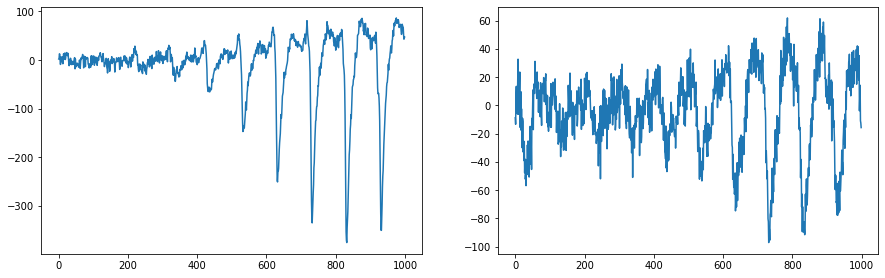

In [155]:
plt.figure(figsize=(15,10))
plt.subplot(221)
plt.plot(rec[40:50,100:200].reshape(-1))
plt.subplot(222)
plt.plot(vomp[40:50,100:200].reshape(-1))

<AxesSubplot:>

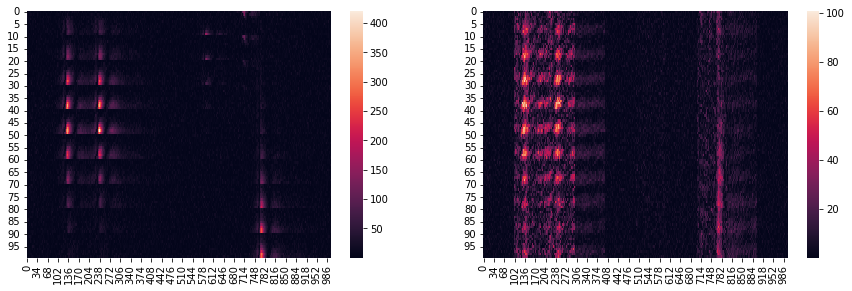

In [156]:
plt.figure(figsize=(15,10))
plt.subplot(221)
sns.heatmap(abs(rec))
plt.subplot(222)
sns.heatmap(abs(vomp))

### same recovery with LARS:

In [157]:
class cs_layer:
    def __init__(self, d, m, phi, k_sparse):
        self.d = d
        self.m = m
        self.phi = phi
        self.k = k_sparse    

    def cs_gen(self):

        for w in self.d:
            y = np.dot(m, w.numpy().reshape(-1))
            lars = Lars(n_nonzero_coefs=k_sparse, normalize=False)
            lars.fit(phi.real, y)
            coef_lars_real = lars.coef_ 
            lars.fit(phi.imag, y)
            coef_lars_img = lars.coef_ 
            coef_lars = coef_lars_real + 1j*coef_lars_img   
            yield coef_lars
            
    def cs_recovery(self):
        d = tf.data.Dataset.from_generator(self.cs_gen, 
                                              output_types=tf.complex64)
        return d

In [158]:
vlars = np.zeros((nch,ns))
for j, elm in enumerate(mr):
    print('epoch-----------%s'%(str(j)))
    wr = fft(elm.numpy()).real/np.sqrt(nch*win_size)
    vlars[:,j*win_size:(j+1)*win_size] = wr.reshape(nch, win_size)

/links/groups/hierlemann/spikesorting/miniconda3/envs/eazizi/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:652: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 22 iterations, i.e. alpha=1.361e-02, with an active set of 22 regressors, and the smallest cholesky pivot element being 3.725e-09. Reduce max_iter or increase eps parameters.
  warnings.warn(
/links/groups/hierlemann/spikesorting/miniconda3/envs/eazizi/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:652: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 58 iterations, i.e. alpha=1.047e-02, with an active set of 58 regressors, and the smallest cholesky pivot element being 3.725e-09. Reduce max_iter or increase eps parameters.
  warnings.warn(
/links/groups/hierlemann/spikesorting/miniconda3/envs/eazizi/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:652: ConvergenceWarning: Regressors in active set degenera

epoch-----------0


/links/groups/hierlemann/spikesorting/miniconda3/envs/eazizi/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:652: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=1.082e-01, with an active set of 5 regressors, and the smallest cholesky pivot element being 2.634e-09. Reduce max_iter or increase eps parameters.
  warnings.warn(
/links/groups/hierlemann/spikesorting/miniconda3/envs/eazizi/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:652: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=1.082e-01, with an active set of 5 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/links/groups/hierlemann/spikesorting/miniconda3/envs/eazizi/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:652: ConvergenceWarning: Regressors in active set degenerate. 

epoch-----------1


/links/groups/hierlemann/spikesorting/miniconda3/envs/eazizi/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:652: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 9 iterations, i.e. alpha=7.307e-02, with an active set of 9 regressors, and the smallest cholesky pivot element being 4.563e-09. Reduce max_iter or increase eps parameters.
  warnings.warn(
/links/groups/hierlemann/spikesorting/miniconda3/envs/eazizi/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:652: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 11 iterations, i.e. alpha=6.953e-02, with an active set of 11 regressors, and the smallest cholesky pivot element being 4.563e-09. Reduce max_iter or increase eps parameters.
  warnings.warn(
/links/groups/hierlemann/spikesorting/miniconda3/envs/eazizi/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:652: ConvergenceWarning: Regressors in active set degenerate

/links/groups/hierlemann/spikesorting/miniconda3/envs/eazizi/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:652: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 82 iterations, i.e. alpha=4.624e-02, with an active set of 81 regressors, and the smallest cholesky pivot element being 3.725e-09. Reduce max_iter or increase eps parameters.
  warnings.warn(
/links/groups/hierlemann/spikesorting/miniconda3/envs/eazizi/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:652: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 82 iterations, i.e. alpha=4.624e-02, with an active set of 81 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/links/groups/hierlemann/spikesorting/miniconda3/envs/eazizi/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:652: ConvergenceWarning: Regressors in active set degenera

epoch-----------2


/links/groups/hierlemann/spikesorting/miniconda3/envs/eazizi/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:652: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 93 iterations, i.e. alpha=1.228e-02, with an active set of 92 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/links/groups/hierlemann/spikesorting/miniconda3/envs/eazizi/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:652: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 93 iterations, i.e. alpha=1.228e-02, with an active set of 92 regressors, and the smallest cholesky pivot element being 3.725e-09. Reduce max_iter or increase eps parameters.
  warnings.warn(
/links/groups/hierlemann/spikesorting/miniconda3/envs/eazizi/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:652: ConvergenceWarning: Regressors in active set degenera

epoch-----------3


/links/groups/hierlemann/spikesorting/miniconda3/envs/eazizi/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:652: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 23 iterations, i.e. alpha=1.266e-02, with an active set of 23 regressors, and the smallest cholesky pivot element being 2.634e-09. Reduce max_iter or increase eps parameters.
  warnings.warn(
/links/groups/hierlemann/spikesorting/miniconda3/envs/eazizi/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:652: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 31 iterations, i.e. alpha=1.166e-02, with an active set of 31 regressors, and the smallest cholesky pivot element being 2.634e-09. Reduce max_iter or increase eps parameters.
  warnings.warn(
/links/groups/hierlemann/spikesorting/miniconda3/envs/eazizi/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:652: ConvergenceWarning: Regressors in active set degenera

epoch-----------4


/links/groups/hierlemann/spikesorting/miniconda3/envs/eazizi/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:652: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 17 iterations, i.e. alpha=1.934e-02, with an active set of 17 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/links/groups/hierlemann/spikesorting/miniconda3/envs/eazizi/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:652: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 17 iterations, i.e. alpha=1.934e-02, with an active set of 17 regressors, and the smallest cholesky pivot element being 4.563e-09. Reduce max_iter or increase eps parameters.
  warnings.warn(
/links/groups/hierlemann/spikesorting/miniconda3/envs/eazizi/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:652: ConvergenceWarning: Regressors in active set degenera

epoch-----------5


/links/groups/hierlemann/spikesorting/miniconda3/envs/eazizi/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:652: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 29 iterations, i.e. alpha=1.431e-02, with an active set of 29 regressors, and the smallest cholesky pivot element being 3.725e-09. Reduce max_iter or increase eps parameters.
  warnings.warn(
/links/groups/hierlemann/spikesorting/miniconda3/envs/eazizi/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:652: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 29 iterations, i.e. alpha=1.431e-02, with an active set of 29 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/links/groups/hierlemann/spikesorting/miniconda3/envs/eazizi/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:652: ConvergenceWarning: Regressors in active set degenera

epoch-----------6


/links/groups/hierlemann/spikesorting/miniconda3/envs/eazizi/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:652: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=7.905e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.634e-09. Reduce max_iter or increase eps parameters.
  warnings.warn(
/links/groups/hierlemann/spikesorting/miniconda3/envs/eazizi/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:652: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 11 iterations, i.e. alpha=5.161e-02, with an active set of 11 regressors, and the smallest cholesky pivot element being 2.634e-09. Reduce max_iter or increase eps parameters.
  warnings.warn(
/links/groups/hierlemann/spikesorting/miniconda3/envs/eazizi/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:652: ConvergenceWarning: Regressors in active set degenerate

/links/groups/hierlemann/spikesorting/miniconda3/envs/eazizi/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:652: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 64 iterations, i.e. alpha=3.758e-02, with an active set of 64 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/links/groups/hierlemann/spikesorting/miniconda3/envs/eazizi/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:652: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 64 iterations, i.e. alpha=3.758e-02, with an active set of 64 regressors, and the smallest cholesky pivot element being 4.563e-09. Reduce max_iter or increase eps parameters.
  warnings.warn(
/links/groups/hierlemann/spikesorting/miniconda3/envs/eazizi/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:652: ConvergenceWarning: Regressors in active set degenera

epoch-----------7


/links/groups/hierlemann/spikesorting/miniconda3/envs/eazizi/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:652: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 9 iterations, i.e. alpha=2.579e-02, with an active set of 9 regressors, and the smallest cholesky pivot element being 2.634e-09. Reduce max_iter or increase eps parameters.
  warnings.warn(
/links/groups/hierlemann/spikesorting/miniconda3/envs/eazizi/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:652: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 9 iterations, i.e. alpha=2.579e-02, with an active set of 9 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/links/groups/hierlemann/spikesorting/miniconda3/envs/eazizi/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:652: ConvergenceWarning: Regressors in active set degenerate. 

epoch-----------8
epoch-----------9


/links/groups/hierlemann/spikesorting/miniconda3/envs/eazizi/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:652: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 16 iterations, i.e. alpha=1.265e-02, with an active set of 16 regressors, and the smallest cholesky pivot element being 2.634e-09. Reduce max_iter or increase eps parameters.
  warnings.warn(
/links/groups/hierlemann/spikesorting/miniconda3/envs/eazizi/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:652: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 16 iterations, i.e. alpha=1.265e-02, with an active set of 16 regressors, and the smallest cholesky pivot element being 3.725e-09. Reduce max_iter or increase eps parameters.
  warnings.warn(
/links/groups/hierlemann/spikesorting/miniconda3/envs/eazizi/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:652: ConvergenceWarning: Regressors in active set degenera

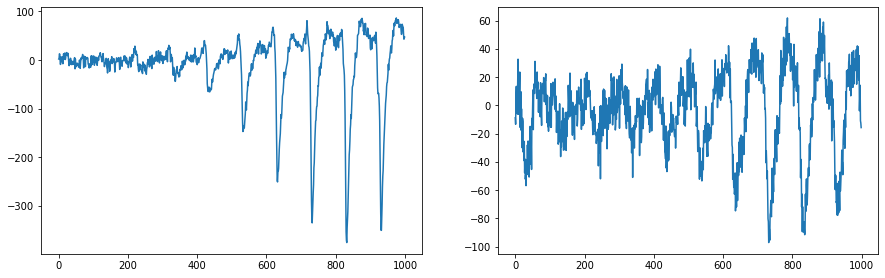

In [159]:
plt.figure(figsize=(15,10))
plt.subplot(221)
plt.plot(rec[40:50,100:200].reshape(-1))
plt.subplot(222)
plt.plot(vlars[40:50,100:200].reshape(-1))

<AxesSubplot:>

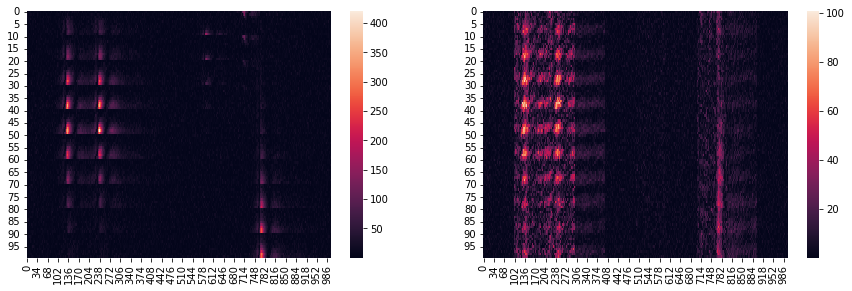

In [160]:
plt.figure(figsize=(15,10))
plt.subplot(221)
sns.heatmap(abs(rec))
plt.subplot(222)
sns.heatmap(abs(vlars))

### NeuroPixels-384

In [26]:
# recordings_params = mr.get_default_recordings_params()
# recordings_params['spiketrains']['duration'] = 60
# recordings_params['recordings']['noise_level'] = 5
# recordings_params['spiketrains']['n_exc'] = 22
# recordings_params['spiketrains']['n_inh'] = 8
# recordings_params['seeds']['spiketrains'] = 12
# recordings_params['seeds']['templates'] = 23
# recordings_params['seeds']['noise'] = 34
# recordings_params['seeds']['convolution'] = 45
# recgen = mr.gen_recordings(params=recordings_params, templates='templates_100_Neuropixels-384.h5')
# mr.save_recording_generator(recgen, 'recordings_100_Neuropixels-384.h5')

In [27]:
# we = si.extract_waveforms(recording, gt, 'tmp', overwrite=True)
# sw.plot_unit_localization(we)

In [89]:
recording, gt = se.read_mearec('recordings_100_Neuropixels-384.h5')
sv = recording.get_traces().T

In [90]:
win_size = 100
hop = win_size # for now let's just consider no overlapping
win = signal.windows.boxcar(win_size, sym=True)
pl = 0
rec = sv[:,3500:4500]
nch, ns = rec.shape
d = Windowing_layer(rec, win, hop, pl).win_set()
print(d)

<FlatMapDataset element_spec=TensorSpec(shape=(384, 100), dtype=tf.float32, name=None)>


In [93]:
v_test = np.zeros((nch,ns))
for i, elm in enumerate(d):
    v_test[:,i*win_size:(i+1)*win_size]=elm

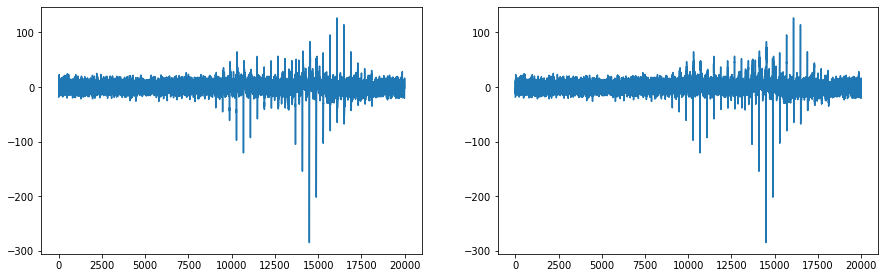

In [99]:
plt.figure(figsize=(15,10))
plt.subplot(221)
plt.plot(rec[50:100,100:500].reshape(-1))
plt.subplot(222)
plt.plot(v_test[50:100,100:500].reshape(-1))

<AxesSubplot:>

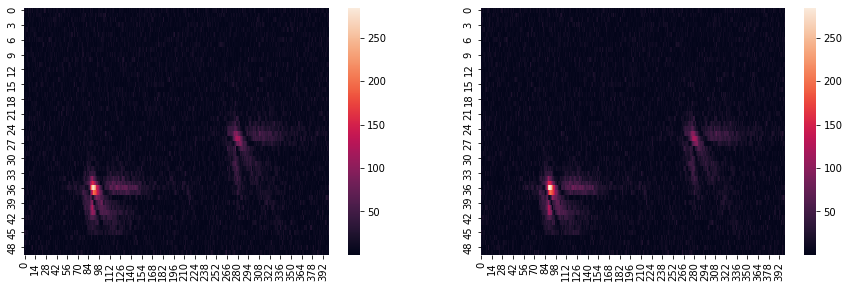

In [101]:
plt.figure(figsize=(15,10))
plt.subplot(221)
sns.heatmap(abs(rec[50:100,100:500]))
plt.subplot(222)
sns.heatmap(abs(v_test[50:100,100:500]))

In [134]:
k1 = 1
k = nch*win_size//100
delta = .5
l = nch*win_size
nm, p = pre_rip(k1, delta, l, k)
print('# of measurements = %s or %s %%'%(nm, 100*nm/(nch*win_size)))
print('probability of satisfiable RIP = ', p)

# of measurements = 1768 or 4.604166666666667 %
probability of satisfiable RIP =  1.0


In [108]:
df = dft(nch*win_size, 'sqrtn')
m = np.random.uniform(0, 1/np.sqrt(nm), (nm, nch*win_size))
phi = np.dot(m, np.conjugate(df).T)
print('dft shape: ',df.shape)
print('dft shape: ',m.shape)
print('dft shape: ',phi.shape)

dft shape:  (38400, 38400)
dft shape:  (1768, 38400)
dft shape:  (1768, 38400)


In [109]:
k_sparse = nch*win_size//100
csl = cs_layer(d, m, phi, k_sparse)
mr = csl.cs_recovery()
print(mr)

<FlatMapDataset element_spec=TensorSpec(shape=<unknown>, dtype=tf.complex64, name=None)>


In [110]:
vlars = np.zeros((nch,ns))
for j, elm in enumerate(mr):
    print('epoch-----------%s'%(str(j)))
    wr = fft(elm.numpy()).real/np.sqrt(nch*win_size)
    vlars[:,j*win_size:(j+1)*win_size] = wr.reshape(nch, win_size)

/links/groups/hierlemann/spikesorting/miniconda3/envs/eazizi/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:652: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=8.083e-03, with an active set of 7 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/links/groups/hierlemann/spikesorting/miniconda3/envs/eazizi/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:652: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=8.083e-03, with an active set of 7 regressors, and the smallest cholesky pivot element being 2.634e-09. Reduce max_iter or increase eps parameters.
  warnings.warn(
/links/groups/hierlemann/spikesorting/miniconda3/envs/eazizi/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:652: ConvergenceWarning: Regressors in active set degenerate. 

/links/groups/hierlemann/spikesorting/miniconda3/envs/eazizi/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:652: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 321 iterations, i.e. alpha=4.138e-03, with an active set of 321 regressors, and the smallest cholesky pivot element being 4.563e-09. Reduce max_iter or increase eps parameters.
  warnings.warn(
/links/groups/hierlemann/spikesorting/miniconda3/envs/eazizi/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:652: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 339 iterations, i.e. alpha=4.082e-03, with an active set of 339 regressors, and the smallest cholesky pivot element being 4.563e-09. Reduce max_iter or increase eps parameters.
  warnings.warn(
/links/groups/hierlemann/spikesorting/miniconda3/envs/eazizi/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:652: ConvergenceWarning: Regressors in active set dege

/links/groups/hierlemann/spikesorting/miniconda3/envs/eazizi/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:652: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 65 iterations, i.e. alpha=5.949e-03, with an active set of 65 regressors, and the smallest cholesky pivot element being 4.563e-09. Reduce max_iter or increase eps parameters.
  warnings.warn(
/links/groups/hierlemann/spikesorting/miniconda3/envs/eazizi/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:652: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 82 iterations, i.e. alpha=5.800e-03, with an active set of 82 regressors, and the smallest cholesky pivot element being 3.725e-09. Reduce max_iter or increase eps parameters.
  warnings.warn(
/links/groups/hierlemann/spikesorting/miniconda3/envs/eazizi/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:652: ConvergenceWarning: Regressors in active set degenera

/links/groups/hierlemann/spikesorting/miniconda3/envs/eazizi/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:652: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 327 iterations, i.e. alpha=3.985e-03, with an active set of 327 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/links/groups/hierlemann/spikesorting/miniconda3/envs/eazizi/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:652: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 341 iterations, i.e. alpha=3.963e-03, with an active set of 341 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/links/groups/hierlemann/spikesorting/miniconda3/envs/eazizi/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:652: ConvergenceWarning: Regressors in active set dege

epoch-----------0


/links/groups/hierlemann/spikesorting/miniconda3/envs/eazizi/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:652: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=1.236e-02, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/links/groups/hierlemann/spikesorting/miniconda3/envs/eazizi/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:652: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 17 iterations, i.e. alpha=7.232e-03, with an active set of 17 regressors, and the smallest cholesky pivot element being 2.634e-09. Reduce max_iter or increase eps parameters.
  warnings.warn(
/links/groups/hierlemann/spikesorting/miniconda3/envs/eazizi/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:652: ConvergenceWarning: Regressors in active set degenerate

/links/groups/hierlemann/spikesorting/miniconda3/envs/eazizi/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:652: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 177 iterations, i.e. alpha=5.183e-03, with an active set of 177 regressors, and the smallest cholesky pivot element being 2.634e-09. Reduce max_iter or increase eps parameters.
  warnings.warn(
/links/groups/hierlemann/spikesorting/miniconda3/envs/eazizi/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:652: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 177 iterations, i.e. alpha=5.183e-03, with an active set of 177 regressors, and the smallest cholesky pivot element being 3.725e-09. Reduce max_iter or increase eps parameters.
  warnings.warn(
/links/groups/hierlemann/spikesorting/miniconda3/envs/eazizi/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:652: ConvergenceWarning: Regressors in active set dege

/links/groups/hierlemann/spikesorting/miniconda3/envs/eazizi/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:652: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 337 iterations, i.e. alpha=4.204e-03, with an active set of 337 regressors, and the smallest cholesky pivot element being 2.634e-09. Reduce max_iter or increase eps parameters.
  warnings.warn(
/links/groups/hierlemann/spikesorting/miniconda3/envs/eazizi/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:652: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 337 iterations, i.e. alpha=4.204e-03, with an active set of 337 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/links/groups/hierlemann/spikesorting/miniconda3/envs/eazizi/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:652: ConvergenceWarning: Regressors in active set dege

/links/groups/hierlemann/spikesorting/miniconda3/envs/eazizi/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:652: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 98 iterations, i.e. alpha=5.619e-03, with an active set of 98 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/links/groups/hierlemann/spikesorting/miniconda3/envs/eazizi/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:652: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 109 iterations, i.e. alpha=5.529e-03, with an active set of 109 regressors, and the smallest cholesky pivot element being 4.563e-09. Reduce max_iter or increase eps parameters.
  warnings.warn(
/links/groups/hierlemann/spikesorting/miniconda3/envs/eazizi/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:652: ConvergenceWarning: Regressors in active set degene

/links/groups/hierlemann/spikesorting/miniconda3/envs/eazizi/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:652: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 321 iterations, i.e. alpha=4.163e-03, with an active set of 320 regressors, and the smallest cholesky pivot element being 4.563e-09. Reduce max_iter or increase eps parameters.
  warnings.warn(
/links/groups/hierlemann/spikesorting/miniconda3/envs/eazizi/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:652: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 321 iterations, i.e. alpha=4.163e-03, with an active set of 320 regressors, and the smallest cholesky pivot element being 3.725e-09. Reduce max_iter or increase eps parameters.
  warnings.warn(
/links/groups/hierlemann/spikesorting/miniconda3/envs/eazizi/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:652: ConvergenceWarning: Regressors in active set dege

epoch-----------1


/links/groups/hierlemann/spikesorting/miniconda3/envs/eazizi/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:652: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 14 iterations, i.e. alpha=6.129e-03, with an active set of 14 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/links/groups/hierlemann/spikesorting/miniconda3/envs/eazizi/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:652: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 89 iterations, i.e. alpha=4.519e-03, with an active set of 89 regressors, and the smallest cholesky pivot element being 3.725e-09. Reduce max_iter or increase eps parameters.
  warnings.warn(
/links/groups/hierlemann/spikesorting/miniconda3/envs/eazizi/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:652: ConvergenceWarning: Regressors in active set degenera

/links/groups/hierlemann/spikesorting/miniconda3/envs/eazizi/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:652: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 239 iterations, i.e. alpha=3.506e-03, with an active set of 239 regressors, and the smallest cholesky pivot element being 3.725e-09. Reduce max_iter or increase eps parameters.
  warnings.warn(
/links/groups/hierlemann/spikesorting/miniconda3/envs/eazizi/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:652: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 247 iterations, i.e. alpha=3.487e-03, with an active set of 247 regressors, and the smallest cholesky pivot element being 2.634e-09. Reduce max_iter or increase eps parameters.
  warnings.warn(
/links/groups/hierlemann/spikesorting/miniconda3/envs/eazizi/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:652: ConvergenceWarning: Regressors in active set dege

/links/groups/hierlemann/spikesorting/miniconda3/envs/eazizi/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:652: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 27 iterations, i.e. alpha=5.878e-03, with an active set of 27 regressors, and the smallest cholesky pivot element being 2.634e-09. Reduce max_iter or increase eps parameters.
  warnings.warn(
/links/groups/hierlemann/spikesorting/miniconda3/envs/eazizi/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:652: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 34 iterations, i.e. alpha=5.696e-03, with an active set of 34 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/links/groups/hierlemann/spikesorting/miniconda3/envs/eazizi/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:652: ConvergenceWarning: Regressors in active set degenera

/links/groups/hierlemann/spikesorting/miniconda3/envs/eazizi/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:652: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 190 iterations, i.e. alpha=3.998e-03, with an active set of 190 regressors, and the smallest cholesky pivot element being 3.725e-09. Reduce max_iter or increase eps parameters.
  warnings.warn(
/links/groups/hierlemann/spikesorting/miniconda3/envs/eazizi/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:652: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 230 iterations, i.e. alpha=3.780e-03, with an active set of 230 regressors, and the smallest cholesky pivot element being 2.634e-09. Reduce max_iter or increase eps parameters.
  warnings.warn(
/links/groups/hierlemann/spikesorting/miniconda3/envs/eazizi/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:652: ConvergenceWarning: Regressors in active set dege

epoch-----------2


/links/groups/hierlemann/spikesorting/miniconda3/envs/eazizi/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:652: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 65 iterations, i.e. alpha=5.525e-03, with an active set of 65 regressors, and the smallest cholesky pivot element being 3.725e-09. Reduce max_iter or increase eps parameters.
  warnings.warn(
/links/groups/hierlemann/spikesorting/miniconda3/envs/eazizi/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:652: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 90 iterations, i.e. alpha=5.289e-03, with an active set of 90 regressors, and the smallest cholesky pivot element being 2.634e-09. Reduce max_iter or increase eps parameters.
  warnings.warn(
/links/groups/hierlemann/spikesorting/miniconda3/envs/eazizi/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:652: ConvergenceWarning: Regressors in active set degenera

/links/groups/hierlemann/spikesorting/miniconda3/envs/eazizi/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:652: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 250 iterations, i.e. alpha=4.258e-03, with an active set of 250 regressors, and the smallest cholesky pivot element being 2.634e-09. Reduce max_iter or increase eps parameters.
  warnings.warn(
/links/groups/hierlemann/spikesorting/miniconda3/envs/eazizi/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:652: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 260 iterations, i.e. alpha=4.204e-03, with an active set of 260 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/links/groups/hierlemann/spikesorting/miniconda3/envs/eazizi/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:652: ConvergenceWarning: Regressors in active set dege

/links/groups/hierlemann/spikesorting/miniconda3/envs/eazizi/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:652: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 104 iterations, i.e. alpha=5.002e-03, with an active set of 104 regressors, and the smallest cholesky pivot element being 2.634e-09. Reduce max_iter or increase eps parameters.
  warnings.warn(
/links/groups/hierlemann/spikesorting/miniconda3/envs/eazizi/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:652: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 108 iterations, i.e. alpha=4.958e-03, with an active set of 108 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/links/groups/hierlemann/spikesorting/miniconda3/envs/eazizi/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:652: ConvergenceWarning: Regressors in active set dege

/links/groups/hierlemann/spikesorting/miniconda3/envs/eazizi/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:652: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 256 iterations, i.e. alpha=3.891e-03, with an active set of 256 regressors, and the smallest cholesky pivot element being 5.890e-09. Reduce max_iter or increase eps parameters.
  warnings.warn(
/links/groups/hierlemann/spikesorting/miniconda3/envs/eazizi/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:652: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 295 iterations, i.e. alpha=3.726e-03, with an active set of 295 regressors, and the smallest cholesky pivot element being 2.634e-09. Reduce max_iter or increase eps parameters.
  warnings.warn(
/links/groups/hierlemann/spikesorting/miniconda3/envs/eazizi/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:652: ConvergenceWarning: Regressors in active set dege

epoch-----------3


/links/groups/hierlemann/spikesorting/miniconda3/envs/eazizi/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:652: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 13 iterations, i.e. alpha=5.476e-03, with an active set of 13 regressors, and the smallest cholesky pivot element being 2.634e-09. Reduce max_iter or increase eps parameters.
  warnings.warn(
/links/groups/hierlemann/spikesorting/miniconda3/envs/eazizi/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:652: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 55 iterations, i.e. alpha=4.480e-03, with an active set of 55 regressors, and the smallest cholesky pivot element being 4.563e-09. Reduce max_iter or increase eps parameters.
  warnings.warn(
/links/groups/hierlemann/spikesorting/miniconda3/envs/eazizi/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:652: ConvergenceWarning: Regressors in active set degenera

/links/groups/hierlemann/spikesorting/miniconda3/envs/eazizi/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:652: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 326 iterations, i.e. alpha=2.887e-03, with an active set of 326 regressors, and the smallest cholesky pivot element being 4.563e-09. Reduce max_iter or increase eps parameters.
  warnings.warn(
/links/groups/hierlemann/spikesorting/miniconda3/envs/eazizi/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:652: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 362 iterations, i.e. alpha=2.792e-03, with an active set of 362 regressors, and the smallest cholesky pivot element being 2.634e-09. Reduce max_iter or increase eps parameters.
  warnings.warn(
/links/groups/hierlemann/spikesorting/miniconda3/envs/eazizi/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:652: ConvergenceWarning: Regressors in active set dege

/links/groups/hierlemann/spikesorting/miniconda3/envs/eazizi/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:652: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 92 iterations, i.e. alpha=3.740e-03, with an active set of 92 regressors, and the smallest cholesky pivot element being 2.634e-09. Reduce max_iter or increase eps parameters.
  warnings.warn(
/links/groups/hierlemann/spikesorting/miniconda3/envs/eazizi/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:652: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 93 iterations, i.e. alpha=3.739e-03, with an active set of 93 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/links/groups/hierlemann/spikesorting/miniconda3/envs/eazizi/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:652: ConvergenceWarning: Regressors in active set degenera

/links/groups/hierlemann/spikesorting/miniconda3/envs/eazizi/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:652: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 312 iterations, i.e. alpha=2.809e-03, with an active set of 311 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/links/groups/hierlemann/spikesorting/miniconda3/envs/eazizi/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:652: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 332 iterations, i.e. alpha=2.742e-03, with an active set of 330 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/links/groups/hierlemann/spikesorting/miniconda3/envs/eazizi/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:652: ConvergenceWarning: Regressors in active set dege

epoch-----------4


/links/groups/hierlemann/spikesorting/miniconda3/envs/eazizi/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:652: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 16 iterations, i.e. alpha=5.257e-03, with an active set of 16 regressors, and the smallest cholesky pivot element being 3.725e-09. Reduce max_iter or increase eps parameters.
  warnings.warn(
/links/groups/hierlemann/spikesorting/miniconda3/envs/eazizi/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:652: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 16 iterations, i.e. alpha=5.257e-03, with an active set of 16 regressors, and the smallest cholesky pivot element being 5.268e-09. Reduce max_iter or increase eps parameters.
  warnings.warn(
/links/groups/hierlemann/spikesorting/miniconda3/envs/eazizi/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:652: ConvergenceWarning: Regressors in active set degenera

/links/groups/hierlemann/spikesorting/miniconda3/envs/eazizi/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:652: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 349 iterations, i.e. alpha=2.732e-03, with an active set of 349 regressors, and the smallest cholesky pivot element being 5.268e-09. Reduce max_iter or increase eps parameters.
  warnings.warn(
/links/groups/hierlemann/spikesorting/miniconda3/envs/eazizi/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:652: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 349 iterations, i.e. alpha=2.732e-03, with an active set of 349 regressors, and the smallest cholesky pivot element being 4.563e-09. Reduce max_iter or increase eps parameters.
  warnings.warn(
/links/groups/hierlemann/spikesorting/miniconda3/envs/eazizi/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:652: ConvergenceWarning: Regressors in active set dege

/links/groups/hierlemann/spikesorting/miniconda3/envs/eazizi/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:652: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 263 iterations, i.e. alpha=3.137e-03, with an active set of 263 regressors, and the smallest cholesky pivot element being 3.725e-09. Reduce max_iter or increase eps parameters.
  warnings.warn(
/links/groups/hierlemann/spikesorting/miniconda3/envs/eazizi/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:652: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 263 iterations, i.e. alpha=3.137e-03, with an active set of 263 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/links/groups/hierlemann/spikesorting/miniconda3/envs/eazizi/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:652: ConvergenceWarning: Regressors in active set dege

epoch-----------5


/links/groups/hierlemann/spikesorting/miniconda3/envs/eazizi/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:652: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=4.182e-03, with an active set of 6 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/links/groups/hierlemann/spikesorting/miniconda3/envs/eazizi/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:652: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 27 iterations, i.e. alpha=3.598e-03, with an active set of 27 regressors, and the smallest cholesky pivot element being 4.563e-09. Reduce max_iter or increase eps parameters.
  warnings.warn(
/links/groups/hierlemann/spikesorting/miniconda3/envs/eazizi/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:652: ConvergenceWarning: Regressors in active set degenerate

/links/groups/hierlemann/spikesorting/miniconda3/envs/eazizi/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:652: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 117 iterations, i.e. alpha=2.782e-03, with an active set of 117 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/links/groups/hierlemann/spikesorting/miniconda3/envs/eazizi/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:652: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 155 iterations, i.e. alpha=2.630e-03, with an active set of 155 regressors, and the smallest cholesky pivot element being 2.634e-09. Reduce max_iter or increase eps parameters.
  warnings.warn(
/links/groups/hierlemann/spikesorting/miniconda3/envs/eazizi/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:652: ConvergenceWarning: Regressors in active set dege

/links/groups/hierlemann/spikesorting/miniconda3/envs/eazizi/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:652: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 301 iterations, i.e. alpha=2.236e-03, with an active set of 301 regressors, and the smallest cholesky pivot element being 5.268e-09. Reduce max_iter or increase eps parameters.
  warnings.warn(
/links/groups/hierlemann/spikesorting/miniconda3/envs/eazizi/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:652: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 301 iterations, i.e. alpha=2.236e-03, with an active set of 301 regressors, and the smallest cholesky pivot element being 4.563e-09. Reduce max_iter or increase eps parameters.
  warnings.warn(
/links/groups/hierlemann/spikesorting/miniconda3/envs/eazizi/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:652: ConvergenceWarning: Regressors in active set dege

/links/groups/hierlemann/spikesorting/miniconda3/envs/eazizi/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:652: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 151 iterations, i.e. alpha=2.735e-03, with an active set of 151 regressors, and the smallest cholesky pivot element being 2.634e-09. Reduce max_iter or increase eps parameters.
  warnings.warn(
/links/groups/hierlemann/spikesorting/miniconda3/envs/eazizi/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:652: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 180 iterations, i.e. alpha=2.579e-03, with an active set of 180 regressors, and the smallest cholesky pivot element being 2.634e-09. Reduce max_iter or increase eps parameters.
  warnings.warn(
/links/groups/hierlemann/spikesorting/miniconda3/envs/eazizi/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:652: ConvergenceWarning: Regressors in active set dege

epoch-----------6


/links/groups/hierlemann/spikesorting/miniconda3/envs/eazizi/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:652: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 29 iterations, i.e. alpha=3.458e-03, with an active set of 29 regressors, and the smallest cholesky pivot element being 4.563e-09. Reduce max_iter or increase eps parameters.
  warnings.warn(
/links/groups/hierlemann/spikesorting/miniconda3/envs/eazizi/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:652: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 36 iterations, i.e. alpha=3.425e-03, with an active set of 36 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/links/groups/hierlemann/spikesorting/miniconda3/envs/eazizi/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:652: ConvergenceWarning: Regressors in active set degenera

/links/groups/hierlemann/spikesorting/miniconda3/envs/eazizi/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:652: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 238 iterations, i.e. alpha=2.440e-03, with an active set of 238 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/links/groups/hierlemann/spikesorting/miniconda3/envs/eazizi/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:652: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 243 iterations, i.e. alpha=2.429e-03, with an active set of 243 regressors, and the smallest cholesky pivot element being 3.725e-09. Reduce max_iter or increase eps parameters.
  warnings.warn(
/links/groups/hierlemann/spikesorting/miniconda3/envs/eazizi/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:652: ConvergenceWarning: Regressors in active set dege

/links/groups/hierlemann/spikesorting/miniconda3/envs/eazizi/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:652: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 329 iterations, i.e. alpha=2.228e-03, with an active set of 328 regressors, and the smallest cholesky pivot element being 2.634e-09. Reduce max_iter or increase eps parameters.
  warnings.warn(
/links/groups/hierlemann/spikesorting/miniconda3/envs/eazizi/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:652: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 345 iterations, i.e. alpha=2.204e-03, with an active set of 344 regressors, and the smallest cholesky pivot element being 3.725e-09. Reduce max_iter or increase eps parameters.
  warnings.warn(
/links/groups/hierlemann/spikesorting/miniconda3/envs/eazizi/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:652: ConvergenceWarning: Regressors in active set dege

/links/groups/hierlemann/spikesorting/miniconda3/envs/eazizi/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:652: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 175 iterations, i.e. alpha=2.649e-03, with an active set of 175 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/links/groups/hierlemann/spikesorting/miniconda3/envs/eazizi/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:652: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 182 iterations, i.e. alpha=2.619e-03, with an active set of 182 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/links/groups/hierlemann/spikesorting/miniconda3/envs/eazizi/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:652: ConvergenceWarning: Regressors in active set dege

epoch-----------7


/links/groups/hierlemann/spikesorting/miniconda3/envs/eazizi/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:652: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=5.726e-03, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/links/groups/hierlemann/spikesorting/miniconda3/envs/eazizi/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:652: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=5.726e-03, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.634e-09. Reduce max_iter or increase eps parameters.
  warnings.warn(
/links/groups/hierlemann/spikesorting/miniconda3/envs/eazizi/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:652: ConvergenceWarning: Regressors in active set degenerate. 

/links/groups/hierlemann/spikesorting/miniconda3/envs/eazizi/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:652: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 220 iterations, i.e. alpha=3.426e-03, with an active set of 220 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/links/groups/hierlemann/spikesorting/miniconda3/envs/eazizi/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:652: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 220 iterations, i.e. alpha=3.426e-03, with an active set of 220 regressors, and the smallest cholesky pivot element being 2.634e-09. Reduce max_iter or increase eps parameters.
  warnings.warn(
/links/groups/hierlemann/spikesorting/miniconda3/envs/eazizi/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:652: ConvergenceWarning: Regressors in active set dege

/links/groups/hierlemann/spikesorting/miniconda3/envs/eazizi/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:652: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 150 iterations, i.e. alpha=3.721e-03, with an active set of 150 regressors, and the smallest cholesky pivot element being 4.563e-09. Reduce max_iter or increase eps parameters.
  warnings.warn(
/links/groups/hierlemann/spikesorting/miniconda3/envs/eazizi/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:652: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 166 iterations, i.e. alpha=3.671e-03, with an active set of 166 regressors, and the smallest cholesky pivot element being 2.634e-09. Reduce max_iter or increase eps parameters.
  warnings.warn(
/links/groups/hierlemann/spikesorting/miniconda3/envs/eazizi/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:652: ConvergenceWarning: Regressors in active set dege

/links/groups/hierlemann/spikesorting/miniconda3/envs/eazizi/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:652: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 310 iterations, i.e. alpha=3.047e-03, with an active set of 310 regressors, and the smallest cholesky pivot element being 3.725e-09. Reduce max_iter or increase eps parameters.
  warnings.warn(
/links/groups/hierlemann/spikesorting/miniconda3/envs/eazizi/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:652: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 318 iterations, i.e. alpha=3.012e-03, with an active set of 318 regressors, and the smallest cholesky pivot element being 3.725e-09. Reduce max_iter or increase eps parameters.
  warnings.warn(
/links/groups/hierlemann/spikesorting/miniconda3/envs/eazizi/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:652: ConvergenceWarning: Regressors in active set dege

epoch-----------8


/links/groups/hierlemann/spikesorting/miniconda3/envs/eazizi/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:652: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 75 iterations, i.e. alpha=4.265e-03, with an active set of 75 regressors, and the smallest cholesky pivot element being 3.725e-09. Reduce max_iter or increase eps parameters.
  warnings.warn(
/links/groups/hierlemann/spikesorting/miniconda3/envs/eazizi/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:652: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 75 iterations, i.e. alpha=4.265e-03, with an active set of 75 regressors, and the smallest cholesky pivot element being 2.634e-09. Reduce max_iter or increase eps parameters.
  warnings.warn(
/links/groups/hierlemann/spikesorting/miniconda3/envs/eazizi/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:652: ConvergenceWarning: Regressors in active set degenera

/links/groups/hierlemann/spikesorting/miniconda3/envs/eazizi/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:652: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 290 iterations, i.e. alpha=3.140e-03, with an active set of 290 regressors, and the smallest cholesky pivot element being 4.563e-09. Reduce max_iter or increase eps parameters.
  warnings.warn(
/links/groups/hierlemann/spikesorting/miniconda3/envs/eazizi/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:652: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 290 iterations, i.e. alpha=3.140e-03, with an active set of 290 regressors, and the smallest cholesky pivot element being 3.725e-09. Reduce max_iter or increase eps parameters.
  warnings.warn(
/links/groups/hierlemann/spikesorting/miniconda3/envs/eazizi/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:652: ConvergenceWarning: Regressors in active set dege

/links/groups/hierlemann/spikesorting/miniconda3/envs/eazizi/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:652: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 144 iterations, i.e. alpha=3.836e-03, with an active set of 144 regressors, and the smallest cholesky pivot element being 3.725e-09. Reduce max_iter or increase eps parameters.
  warnings.warn(
/links/groups/hierlemann/spikesorting/miniconda3/envs/eazizi/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:652: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 144 iterations, i.e. alpha=3.836e-03, with an active set of 144 regressors, and the smallest cholesky pivot element being 2.634e-09. Reduce max_iter or increase eps parameters.
  warnings.warn(
/links/groups/hierlemann/spikesorting/miniconda3/envs/eazizi/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:652: ConvergenceWarning: Regressors in active set dege

/links/groups/hierlemann/spikesorting/miniconda3/envs/eazizi/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:652: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 322 iterations, i.e. alpha=3.087e-03, with an active set of 322 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/links/groups/hierlemann/spikesorting/miniconda3/envs/eazizi/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:652: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 325 iterations, i.e. alpha=3.083e-03, with an active set of 325 regressors, and the smallest cholesky pivot element being 5.268e-09. Reduce max_iter or increase eps parameters.
  warnings.warn(
/links/groups/hierlemann/spikesorting/miniconda3/envs/eazizi/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:652: ConvergenceWarning: Regressors in active set dege

epoch-----------9


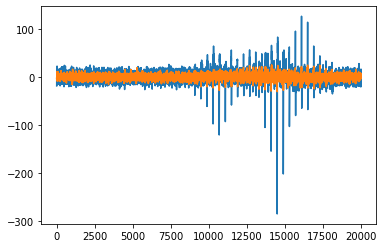

In [111]:
plt.plot(rec[50:100,100:500].reshape(-1))
plt.plot(vlars[50:100,100:500].reshape(-1))

<AxesSubplot:>

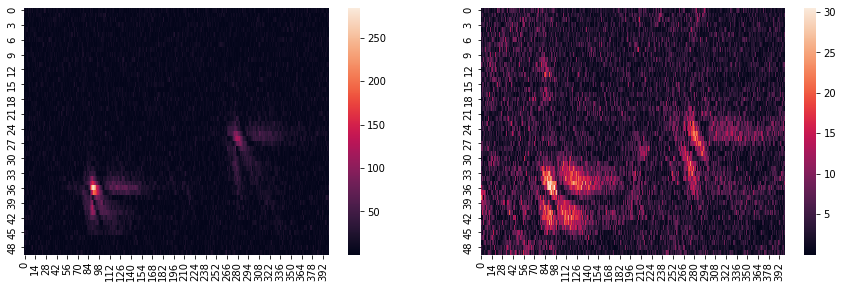

In [112]:
plt.figure(figsize=(15,10))
plt.subplot(221)
sns.heatmap(abs(rec[50:100,100:500]))
plt.subplot(222)
sns.heatmap(abs(vlars[50:100,100:500]))